# Exercise 2: Topic Model Inference in LDA

First, let's import the Python bindings for MeTA:

In [1]:
import metapy

If you don't have `metapy` installed, you can install it with a

```bash
pip install metapy
```

on the command line on Linux, macOS, or Windows for either Python 2.7 or Python 3.x. (I will be using Python 3.6 in this tutorial.)

Double-check that you are running the latest version. Right now, that should be `0.2.10`.

In [2]:
metapy.__version__

'0.2.13'

Now, let's set MeTA to log to standard error so we can see progress output for long-running commands. (Only do this once, or you'll get double the output.)

In [3]:
# Uncomment for detailed (but installation-specific) progress logs
# metapy.log_to_stderr()

Now, let's download all of the files we need for the tutorial.

In [4]:
import urllib.request
import os
import tarfile

if not os.path.exists('sigir18-tutorial.tar.gz'):
    urllib.request.urlretrieve('https://meta-toolkit.org/data/2018-06-25/sigir18-tutorial.tar.gz',
                               'sigir18-tutorial.tar.gz')
    
if not os.path.exists('data'):
    with tarfile.open('sigir18-tutorial.tar.gz', 'r:gz') as files:
        files.extractall()

The tutorial files come with a dataset consisting of four years of NIPS proceedings (full text): 2002, 2007, 2012, and 2017.

To start, we first want to understand what topics are being discussed in NIPS in these for years. To do that, we'll first index the dataset in the `ForwardIndex` format (we want to map documents to the terms that they contain).

In [5]:
fidx = metapy.index.make_forward_index('nips.toml')

Now, let's load in all of the documents into memory so we can start to infer a topic model. I'm going to load them in as a `MulticlassDataset` because each document here has been associated with a label (the year it came from), but you could also load them in as just a standard `Dataset` with no associated labels if you don't plan to use them.

In [6]:
dset = metapy.classify.MulticlassDataset(fidx)

With the documents loaded into memory, we can start to run LDA inference on them to infer the topics and their coverage in each of the documents. There are several choices for inference algorithm in MeTA, so in general you can just pick your favorite. Here, I'm going to pick a parallelized version of Gibbs sampling.

The below will run the sampler for either 1000 iterations or until the log likelihood ($\log P(W \mid Z)$) stabilizes, whichever comes first. (If you want to disable the convergence checking and just run the sampler for a fixed number of iterations, you can add the parameter `convergence=0`.)

In [7]:
model = metapy.topics.LDAParallelGibbs(docs=dset, num_topics=10, alpha=0.1, beta=0.1)
model.run(num_iters=1000)
model.save('lda-pgibbs-nips')

Once the above converges, it will save the results to disk. We can load the results into memory for inspection by loading an instance of the `TopicModel` class:

In [8]:
model = metapy.topics.TopicModel('lda-pgibbs-nips')

What do the topics discussed in NIPS over the last two decades roughly look like?

In [9]:
for topic in range(0, model.num_topics()):
    print("Topic {}:".format(topic + 1))
    for tid, val in model.top_k(topic, 10, metapy.topics.BLTermScorer(model)):
        print("{}: {}".format(fidx.term_text(tid), val))
    print("======\n")

Topic 1:
classifi: 0.035935292157269365
label: 0.02978854771605564
classif: 0.02301546205885294
featur: 0.022295042643184493
data: 0.019720729769164086
regress: 0.019116380356225093
task: 0.017682685093250532
user: 0.016343032865156065
predict: 0.015736567980127708
train: 0.014799866594768932

Topic 2:
graph: 0.04244885432912665
matrix: 0.02517201965668834
estim: 0.024786721162978642
cluster: 0.020946809324030594
xi: 0.017818637905825916
theorem: 0.01632946072936723
edg: 0.015517331342819721
node: 0.015340667632082363
log: 0.01354019154543442
variabl: 0.012267080776292398

Topic 3:
layer: 0.0760148715716003
network: 0.0737760977935884
imag: 0.06614539301879496
deep: 0.0556683810953329
train: 0.04781936766485303
gan: 0.04431055552263435
convolut: 0.03226868349502468
adversari: 0.02623927150061376
arxiv: 0.02515779968413266
architectur: 0.018671126801139415

Topic 4:
kernel: 0.09404221787089329
matrix: 0.024464220614204904
hash: 0.016602880034633893
manifold: 0.013569458511593592
data: 0

# Exercise 3: Text Mining using Topic Models

## Topics over Time

An interesting "mining" question to ask on top of this is whether or not the topics used in NIPS have changed over time. Are certain topics exhibited only in the earlier years, or vice-versa?

To do this, let's take a look at the other output of LDA---the topic proportion vectors associated with each document. Since each document also has a label in our dataset, we can create plots for each topic to see the number of documents that mention a specific topic in a specific year, and to what degree.

We'll start by creating a simple dataset with `pandas`:

In [10]:
import pandas as pd

data = []
for doc in dset:
    proportions = model.topic_distribution(doc.id)
    data.append([dset.label(doc)] + [proportions.probability(i) for i in range(0, model.num_topics())])
df = pd.DataFrame(data, columns=['label'] + ["Topic {}".format(i + 1) for i in range(0, model.num_topics())])

Now, let's plot the results. There a lot of ways to do this, but here I'm going to use a "swarm plot" so we can see where each and every document falls.

Topic 1


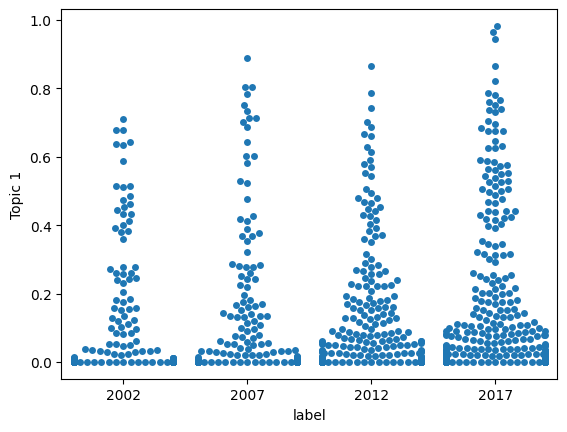

Topic 2


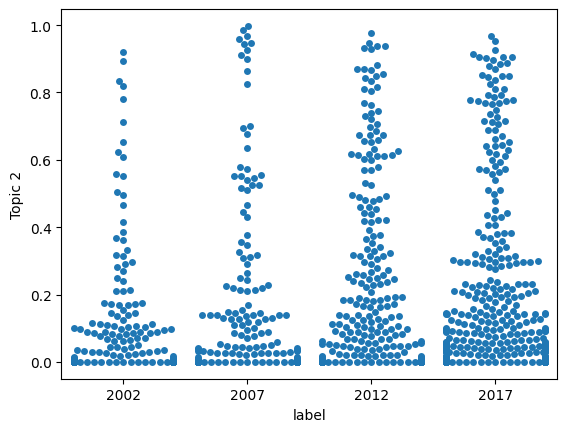

Topic 3


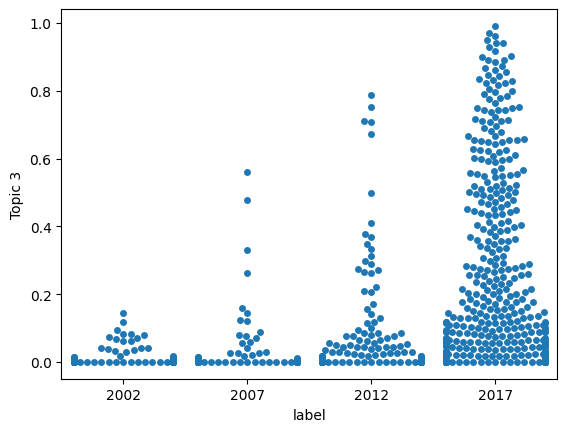

Topic 4


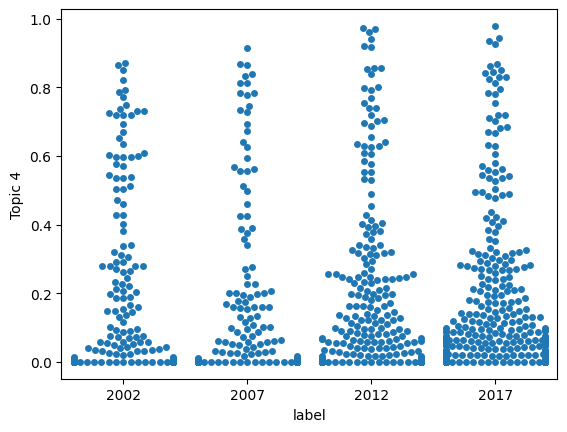

Topic 5


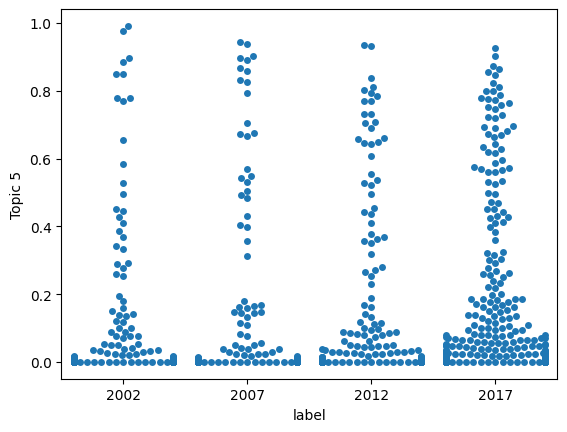

Topic 6


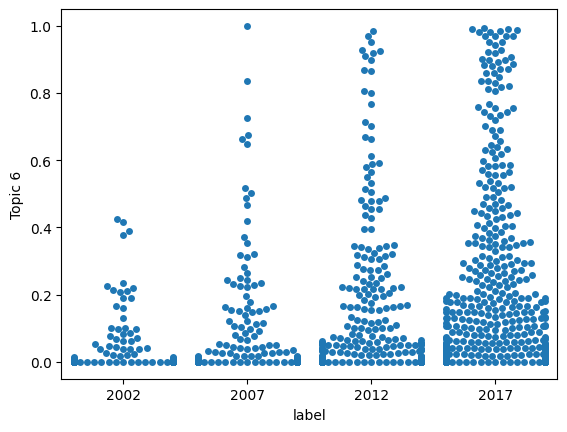

Topic 7


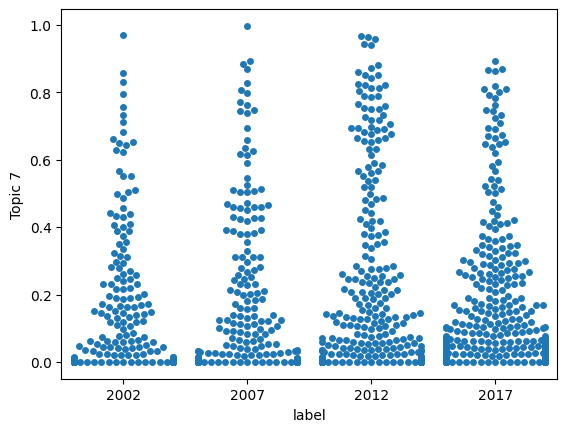

Topic 8


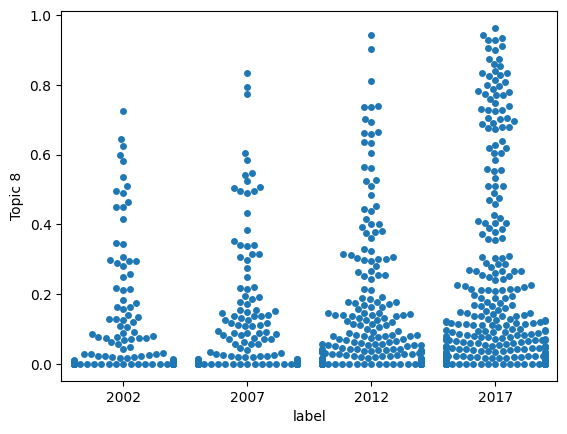

Topic 9


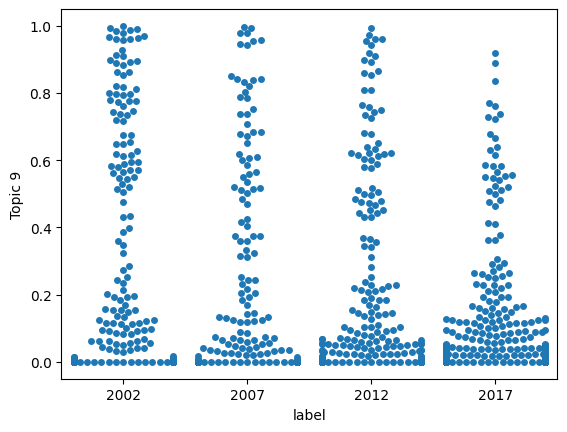

Topic 10


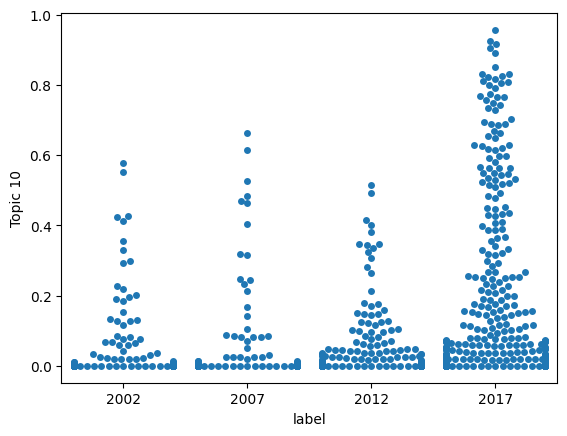

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# otherwise, seaborn is very noisy
warnings.simplefilter('ignore', category=UserWarning)

for i in range(0, model.num_topics()):
    print("Topic {}".format(i + 1))
    sns.swarmplot(data=df, x='label', y="Topic {}".format(i + 1))
    plt.show()

## Topic Inference (Unseen Document)

Let's try to figure out what topics are mentioned in a previously unseen document.

In [12]:
doc = metapy.index.Document()
with open('6589-scan-order-in-gibbs-sampling-models-in-which-it-matters-and-bounds-on-how-much.txt') as f:
    doc.content(f.read())
print("{}...".format(doc.content()[0:500]))

Scan Order in Gibbs Sampling: Models in Which it
Matters and Bounds on How Much
Bryan He, Christopher De Sa, Ioannis Mitliagkas, and Christopher Ré
Stanford University
{bryanhe,cdesa,imit,chrismre}@stanford.edu
Abstract
Gibbs sampling is a Markov Chain Monte Carlo sampling technique that iteratively
samples variables from their conditional distributions. There are two common scan
orders for the variables: random scan and systematic scan. Due to the benefits
of locality in hardware, systematic sc...


We first need to transform the unseen document into the same term-id space used by the topic model.

In [13]:
dvec = fidx.tokenize(doc)

...and then we can create an inferencer on top of our topic model output to infer the topic coverage for this new document:

In [14]:
inferencer = metapy.topics.GibbsInferencer('lda-pgibbs-nips.phi.bin', alpha=0.1)
props = inferencer.infer(dvec, max_iters=100, rng_seed=42)
print(props)

<metapy.stats.Multinomial {0: 0.001111, 1: 0.001111, 2: 0.023333, 3: 0.001111, 4: 0.334444, 5: 0.178889, 6: 0.423333, 7: 0.023333, 8: 0.012222, 9: 0.001111}>


## Classification with Topic Features

The topic proportion vectors are also often used as input to a classifier. In our case, since we see some differences between the years 2002 and 2017 in terms of topical coverage, let's see if we can learn to separate documents that were written in 2002 from documents that were written in 2017 on the basis of their topic proportions alone.

In [15]:
# First, create a lightweight view for shuffling
shuffled_view = metapy.classify.MulticlassDatasetView(dset)
shuffled_view.shuffle()

# this dataset will use unigram words as features
words_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    dset.total_features(),
    lambda doc: metapy.learn.FeatureVector(doc.weights),
    lambda doc: dset.label(doc)
)

# this dataset will use topic proportions as features
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

We'll use a 50/50 training/test split setup.

In [16]:
words_train = words_dset[0:int(len(words_dset)/2)]
words_test = words_dset[int(len(words_dset)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [17]:
def make_linear_svm(training):
    return metapy.classify.OneVsAll(training, metapy.classify.SGD, loss_id='hinge')

words_sgd = make_linear_svm(words_train)
topics_sgd = make_linear_svm(topics_train)

print("Words:")
mtrx = words_sgd.test(words_test)
print(mtrx)
mtrx.print_stats()

print("======")
print("Topics:")
mtrx = topics_sgd.test(topics_test)
print(mtrx)
mtrx.print_stats()

Words:

           2002     2017     
         ------------------
    2002 | 0.948    0.0521   
    2017 | 0.0173   0.983    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.943       0.938       0.948       0.217       
2017        0.984       0.986       0.983       0.783       
------------------------------------------------------------
Total       0.975       0.975       0.975       
------------------------------------------------------------
443 predictions attempted, overall accuracy: 0.975

Topics:

           2002     2017     
         ------------------
    2002 | 0.427    0.573    
    2017 | 0.0605   0.939    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.519       0.661   

While we don't beat unigram words, we still do very well for a model that is only using 10 features compared to the tens of thousands used by the words model:

In [18]:
fidx.unique_terms()

66479

We can also try a straight multiclass classification problem: given a document, predect the year from the topic proportions alone.

In [19]:
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

words_train = shuffled_view[0:int(len(shuffled_view)/2)]
words_test = shuffled_view[int(len(shuffled_view)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [20]:
words_svm = make_linear_svm(words_train)
topics_svm = make_linear_svm(topics_train)

words_mtrx = words_svm.test(words_test)
topics_mtrx = topics_svm.test(topics_test)

print("Words:")
print(words_mtrx)
words_mtrx.print_stats()

print("========")
print("Topics:")
print(topics_mtrx)
topics_mtrx.print_stats()

Words:

           2002     2007     2012     2017     
         ------------------------------------
    2002 | 0.726    0.221    0.0316   0.0211   
    2007 | 0.302    0.33     0.33     0.0377   
    2012 | 0.105    0.183    0.393    0.319    
    2017 | 0.00872  0.0116   0.0581   0.922    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.63        0.556       0.726       0.129       
2007        0.348       0.368       0.33        0.144       
2012        0.463       0.564       0.393       0.26        
2017        0.871       0.826       0.922       0.467       
------------------------------------------------------------
Total       0.665       0.657       0.674       
------------------------------------------------------------
736 predictions attempted, overall accuracy: 0.674

Topics:

           2002     2007     2012     2017   

This is quite a bit harder!